In [16]:
import numpy as np
from codebase.file_utils import save_obj, load_obj, make_folder, path_backslash
from numpy.linalg import inv
from pdb import set_trace
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize
from codebase.plot import *
from scipy import stats
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [2]:
def get_pi_z(z, alpha, beta):
    exp_eta = np.exp(alpha +  z.reshape(1,2) @ beta.T)
    return exp_eta/(1+exp_eta)


In [3]:

np.random.seed(5)
theta_t=dict()
alpha = np.array([0, 0.1, -0.1,-0.2,0.2])
beta = np.array([[1,0.8,0.9,0.5,1.3],[.1,0.8,0.2,0.5,1]]).T
z_t = np.array([-2,1])

y_t = np.random.binomial(1, get_pi_z(z_t, alpha, beta))
y_t

array([[0, 1, 0, 1, 0]])

In [4]:
z_t.shape

(2,)

In [5]:
def get_log_likelihood(z,y,alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    s1 = np.sum(y*np.log(pi_z)+((1.-y)*np.log(1.-pi_z)))
#     s2 = -.5 * np.sum(z**2)
    return s1

def logprior(z):
    return np.sum(multivariate_normal.logpdf(z))

def get_neg_log_likelihood(z,y,alpha, beta):
    return - get_log_likelihood(z,y,alpha, beta)

def get_neg_posterior(z,y,alpha, beta):
    return - (get_log_likelihood(z,y,alpha, beta)+ logprior(z))


lglk = get_log_likelihood(z_t, y_t, alpha, beta) 
lglk

-2.733962295358593

In [6]:
def get_g(z, alpha, beta):
    exp_eta = np.exp(alpha +  z @ beta.T)
    return exp_eta/(1+exp_eta)**2
get_g(z_t, alpha, beta)



array([0.11318026, 0.22171287, 0.13060575, 0.22171287, 0.1586849 ])

In [7]:
def get_jacobian(z, alpha, beta):
    K = beta.shape[1]
    jac = np.empty_like(beta)
    g = get_g(z, alpha, beta)
    for i in range(K):
        jac[:,i] = beta[:,i] * g
    return jac

get_jacobian(z_t, alpha, beta)


array([[0.11318026, 0.01131803],
       [0.1773703 , 0.1773703 ],
       [0.11754517, 0.02612115],
       [0.11085644, 0.11085644],
       [0.20629037, 0.1586849 ]])

In [8]:
def get_c(z, alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    return (pi_z*(1.-pi_z))

get_c(z_t, alpha, beta)


array([[0.11318026, 0.22171287, 0.13060575, 0.22171287, 0.1586849 ]])

In [13]:
def get_fisher_information(z, alpha, beta):
#     P = beta.shape[0]
    K = beta.shape[1]
    
    fm = np.empty((K,K))
    cc = get_c(z_t, alpha, beta)
    jj = get_jacobian(z_t, alpha, beta)
    for i in range(K):
        fm[i,i] = 1+np.sum(jj[:,i]**2/cc)
        for j in range(i):
            fm_ij = np.sum((jj[:,i]*jj[:,j])/cc)
            fm[i,j] = fm_ij
            fm[j,i] = fm_ij
    return fm

get_fisher_information(z_t, alpha, beta)

array([[1.68447285, 0.43844188],
       [0.43844188, 1.36236539]])

In [14]:
get_neg_posterior(z_t,y_t,alpha, beta)

7.071839361767939

In [17]:
def get_laplace_approx(y, alpha, beta):
    res = minimize(get_neg_posterior, np.array([[-2,1]]), args=(y, alpha, beta), method='BFGS')
    cov_matrix = get_fisher_information(res.x, alpha, beta)
    return multivariate_normal(mean = res.x, cov = inv(cov_matrix))
lapldist =  get_laplace_approx(y_t, alpha, beta)
laplace_samples = lapldist.rvs(size = 10000)

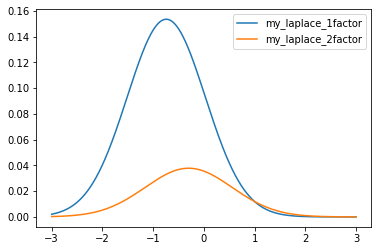

In [33]:

x = np.ones((1000,2)) 
x[:,0] = np.linspace(-3,3,1000)
laplace_pdf1 = lapldist.pdf(x)

y = np.ones((1000,2)) 
y[:,1] = np.linspace(-3,3,1000)
laplace_pdf2 = lapldist.pdf(y)

plt.plot(x[:,0],laplace_pdf1,label='my_laplace_1factor')
plt.plot(y[:,1],laplace_pdf2,label='my_laplace_2factor')
plt.legend()